In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from tqdm import tqdm
import shap
import pickle
import json

model = pickle.load(open('2021-02-01_14:33:17_564376b6-64c4-11eb-993a-1145a5ee830f/model.pkl','rb'))[0]
metadata = json.load(open('2021-02-01_14:33:17_564376b6-64c4-11eb-993a-1145a5ee830f/metadata.json','r'))
feature_used = metadata['feature_names']
len(feature_used),metadata['dev_df_hash'],metadata['dev_jar_hash'],metadata['dev_fe_hash']

(253,
 '0x246c1ac1895140b3',
 'bd1fbbf49c9eac3f1fb3f3fa516f3e46',
 'fd0443730f5306f20d222defd0e46f7d')

In [2]:
dev_extracted = pickle.load(open(f'dev_0x246c1ac1895140b3_bd1fbbf49c9eac3f1fb3f3fa516f3e46_fd0443730f5306f20d222defd0e46f7d.pickle', 'rb'))
sampled_qid = set(dev_extracted['info']['qid'].drop_duplicates().sample(n=100,random_state=12345).to_list())

explainer = shap.TreeExplainer(model)
X = []
shap_values = []

for qid, group in tqdm(dev_extracted['info'].groupby('qid')):
    if qid in sampled_qid:
        sub_X = dev_extracted['data'].loc[group.index, feature_used]
        X.append(sub_X)
        shap_values.append(explainer.shap_values(sub_X))

X = pd.concat(X,axis=0)
shap_values = np.concatenate(shap_values,axis=0)
X.shape, shap_values.shape

100%|██████████| 6980/6980 [11:39<00:00,  9.98it/s]  


((100000, 253), (100000, 253))

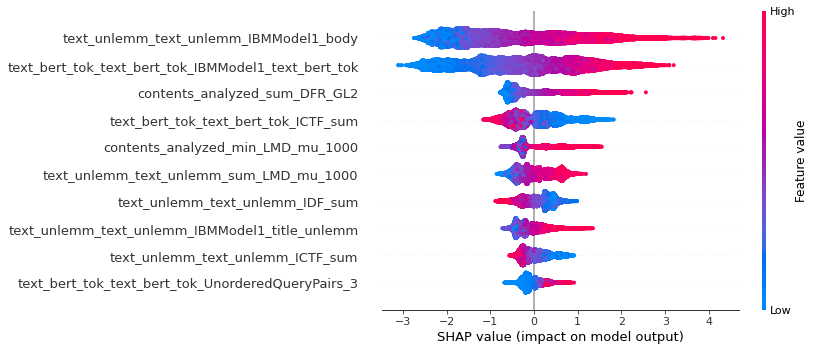

In [3]:
shap.initjs()
shap.summary_plot(shap_values, X, max_display=10)

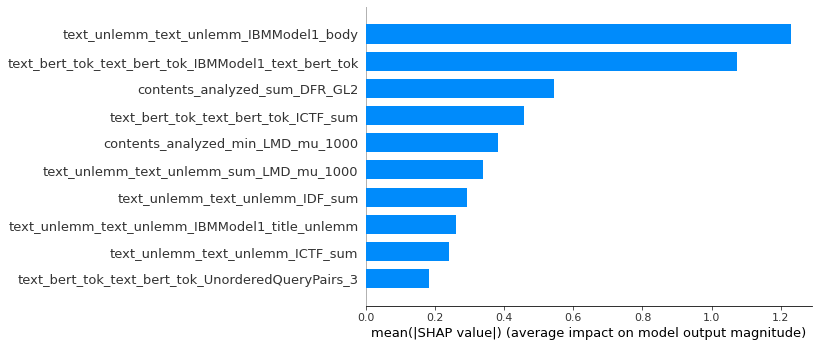

In [4]:
shap.summary_plot(shap_values, X, plot_type="bar", max_display=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

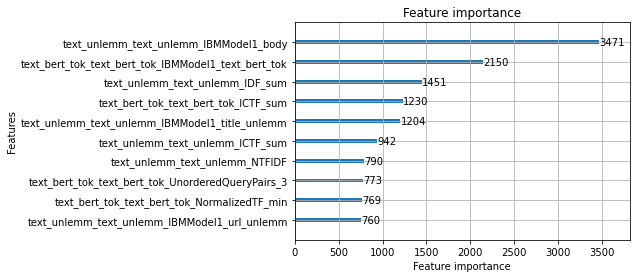

In [5]:
lgb.plot_importance(model, max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

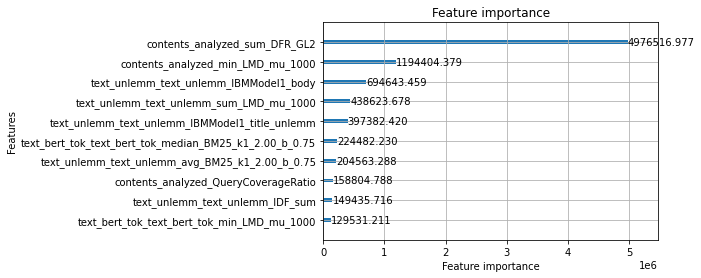

In [6]:
lgb.plot_importance(model, max_num_features=10, importance_type='gain')

In [7]:
fi = np.sum(np.abs(shap_values), axis=0)
fi = fi / fi.sum()
fidx = np.argsort(fi)[::-1]
print('\n'.join(['%s %.2f percent'%(feature_used[idx], fi[idx]*100) for idx in fidx.tolist()[:10]]))

text_unlemm_text_unlemm_IBMModel1_body 13.17 percent
text_bert_tok_text_bert_tok_IBMModel1_text_bert_tok 11.50 percent
contents_analyzed_sum_DFR_GL2 5.84 percent
text_bert_tok_text_bert_tok_ICTF_sum 4.92 percent
contents_analyzed_min_LMD_mu_1000 4.09 percent
text_unlemm_text_unlemm_sum_LMD_mu_1000 3.62 percent
text_unlemm_text_unlemm_IDF_sum 3.15 percent
text_unlemm_text_unlemm_IBMModel1_title_unlemm 2.81 percent
text_unlemm_text_unlemm_ICTF_sum 2.59 percent
text_bert_tok_text_bert_tok_UnorderedQueryPairs_3 1.98 percent


In [8]:
fi = model.feature_importance(importance_type='gain')
fi = fi / fi.sum()
fidx = np.argsort(fi)[::-1]
print('\n'.join(['%s %.2f percent'%(feature_used[idx], fi[idx]*100) for idx in fidx.tolist()[:10]]))

contents_analyzed_sum_DFR_GL2 45.20 percent
contents_analyzed_min_LMD_mu_1000 10.85 percent
text_unlemm_text_unlemm_IBMModel1_body 6.31 percent
text_unlemm_text_unlemm_sum_LMD_mu_1000 3.98 percent
text_unlemm_text_unlemm_IBMModel1_title_unlemm 3.61 percent
text_bert_tok_text_bert_tok_median_BM25_k1_2.00_b_0.75 2.04 percent
text_unlemm_text_unlemm_avg_BM25_k1_2.00_b_0.75 1.86 percent
contents_analyzed_QueryCoverageRatio 1.44 percent
text_unlemm_text_unlemm_IDF_sum 1.36 percent
text_bert_tok_text_bert_tok_min_LMD_mu_1000 1.18 percent


In [9]:
fi = model.feature_importance(importance_type='split')
fi = fi / fi.sum()
fidx = np.argsort(fi)[::-1]
print('\n'.join(['%s %.2f percent'%(feature_used[idx], fi[idx]*100) for idx in fidx.tolist()[:10]]))

text_unlemm_text_unlemm_IBMModel1_body 4.45 percent
text_bert_tok_text_bert_tok_IBMModel1_text_bert_tok 2.76 percent
text_unlemm_text_unlemm_IDF_sum 1.86 percent
text_bert_tok_text_bert_tok_ICTF_sum 1.58 percent
text_unlemm_text_unlemm_IBMModel1_title_unlemm 1.54 percent
text_unlemm_text_unlemm_ICTF_sum 1.21 percent
text_unlemm_text_unlemm_NTFIDF 1.01 percent
text_bert_tok_text_bert_tok_UnorderedQueryPairs_3 0.99 percent
text_bert_tok_text_bert_tok_NormalizedTF_min 0.99 percent
text_unlemm_text_unlemm_IBMModel1_url_unlemm 0.97 percent


In [10]:
fis = zip(feature_used,
       np.sum(np.abs(shap_values), axis=0),
       model.feature_importance(importance_type='split'),
       model.feature_importance(importance_type='gain'))
fis = pd.DataFrame(list(fis),columns=['fn','SHAP','split_num','split_gain']).set_index('fn')
fis = fis.drop('contents_text_unlemm_QueryCoverageRatio')
fis = fis.drop('contents_text_bert_tok_QueryCoverageRatio')
fis

SHAP  split_num  \
fn                                                                             
contents_analyzed_sum_BM25_k1_2.00_b_0.75             1965.942555        284   
contents_analyzed_avg_BM25_k1_2.00_b_0.75             6351.316991        306   
contents_analyzed_median_BM25_k1_2.00_b_0.75           509.834109        218   
contents_analyzed_max_BM25_k1_2.00_b_0.75             1962.156440        399   
contents_analyzed_min_BM25_k1_2.00_b_0.75               43.643827         95   
...                                                           ...        ...   
text_bert_tok_text_bert_tok_OrderedQueryPairs_15      5572.853678        596   
text_unlemm_text_unlemm_IBMModel1_title_unlemm       26250.594480       1204   
text_unlemm_text_unlemm_IBMModel1_url_unlemm         17370.042366        760   
text_unlemm_text_unlemm_IBMModel1_body              122843.129085       3471   
text_bert_tok_text_bert_tok_IBMModel1_text_bert...  107300.893343       2150   

                                                       split_gain  
fn                                                                 
contents_analyzed_sum_BM25_k1_2.00_b_0.75            34378.713660  
contents_analyzed_avg_BM25_k1_2.00_b_0.75            26440.997245  
contents_analyzed_median_BM25_k1_2.00_b_0.75          8696.303053  
contents_analyzed_max_BM25_k1_2.00_b_0.75             7646.979265  
contents_analyzed_min_BM25_k1_2.00_b_0.75             3572.377228  
...                                                           ...  
text_bert_tok_text_bert_tok_OrderedQueryPairs_15     25551.360328  
text_unlemm_text_unlemm_IBMModel1_title_unlemm      397382.420110  
text_unlemm_text_unlemm_IBMModel1_url_unlemm         50521.892560  
text_unlemm_text_unlemm_IBMModel1_body              694643.459005  
text_bert_tok_text_bert_tok_IBMModel1_text_bert...  104351.263250  

[251 rows x 3 columns]

In [11]:
fis['SHAP'] /= fis['SHAP'].sum()
fis['split_num'] /= fis['split_num'].sum()
fis['split_gain'] /= fis['split_gain'].sum()
fis['mean'] = fis['SHAP']*fis['split_gain']
fis.sort_values('mean',ascending=False).head(10)

SHAP  split_num  \
fn                                                                        
contents_analyzed_sum_DFR_GL2                       0.058477   0.005404   
text_unlemm_text_unlemm_IBMModel1_body              0.131821   0.044656   
contents_analyzed_min_LMD_mu_1000                   0.040917   0.007771   
text_unlemm_text_unlemm_sum_LMD_mu_1000             0.036270   0.008247   
text_bert_tok_text_bert_tok_IBMModel1_text_bert...  0.115143   0.027661   
text_unlemm_text_unlemm_IBMModel1_title_unlemm      0.028169   0.015490   
text_unlemm_text_unlemm_IDF_sum                     0.031584   0.018668   
text_bert_tok_text_bert_tok_median_BM25_k1_2.00...  0.018947   0.005159   
text_unlemm_text_unlemm_ICTF_sum                    0.025906   0.012119   
text_bert_tok_text_bert_tok_ICTF_sum                0.049260   0.015825   

                                                    split_gain      mean  
fn                                                                        
contents_analyzed_sum_DFR_GL2                         0.452177  0.026442  
text_unlemm_text_unlemm_IBMModel1_body                0.063117  0.008320  
contents_analyzed_min_LMD_mu_1000                     0.108526  0.004441  
text_unlemm_text_unlemm_sum_LMD_mu_1000               0.039854  0.001446  
text_bert_tok_text_bert_tok_IBMModel1_text_bert...    0.009482  0.001092  
text_unlemm_text_unlemm_IBMModel1_title_unlemm        0.036107  0.001017  
text_unlemm_text_unlemm_IDF_sum                       0.013578  0.000429  
text_bert_tok_text_bert_tok_median_BM25_k1_2.00...    0.020397  0.000386  
text_unlemm_text_unlemm_ICTF_sum                      0.008014  0.000208  
text_bert_tok_text_bert_tok_ICTF_sum                  0.004095  0.000202

<AxesSubplot:>

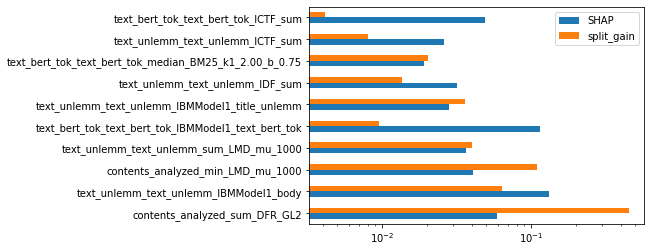

In [12]:
draw_df = fis.sort_values('mean',ascending=False).head(10).copy(deep=True)
del draw_df['mean']
del draw_df['split_num']
draw_df.plot.barh(logx=True,xlabel='')

In [13]:
fis.index.to_list()

['contents_analyzed_sum_BM25_k1_2.00_b_0.75',
 'contents_analyzed_avg_BM25_k1_2.00_b_0.75',
 'contents_analyzed_median_BM25_k1_2.00_b_0.75',
 'contents_analyzed_max_BM25_k1_2.00_b_0.75',
 'contents_analyzed_min_BM25_k1_2.00_b_0.75',
 'contents_analyzed_maxminratio_BM25_k1_2.00_b_0.75',
 'contents_analyzed_sum_LMD_mu_1000',
 'contents_analyzed_avg_LMD_mu_1000',
 'contents_analyzed_median_LMD_mu_1000',
 'contents_analyzed_max_LMD_mu_1000',
 'contents_analyzed_min_LMD_mu_1000',
 'contents_analyzed_maxminratio_LMD_mu_1000',
 'contents_analyzed_NTFIDF',
 'contents_analyzed_Prob',
 'contents_analyzed_sum_DFR_GL2',
 'contents_analyzed_avg_DFR_GL2',
 'contents_analyzed_median_DFR_GL2',
 'contents_analyzed_max_DFR_GL2',
 'contents_analyzed_min_DFR_GL2',
 'contents_analyzed_maxminratio_DFR_GL2',
 'contents_analyzed_sum_DFR_In_expB2',
 'contents_analyzed_avg_DFR_In_expB2',
 'contents_analyzed_median_DFR_In_expB2',
 'contents_analyzed_max_DFR_In_expB2',
 'contents_analyzed_min_DFR_In_expB2',
 'con

In [14]:
import re
from collections import defaultdict
class_list = defaultdict(list)
def classify(fn):
    if re.search('DocSize',fn):
        if re.search('contents',fn):
            return 'analyzed'
        elif re.search('text_unlemm',fn):
            return 'text_unlemm'
        elif re.search('text_bert_tok',fn):
            return 'text_bert_tok'
        else:
            raise Exception('unknown')
    elif re.search('QueryLength',fn):
        if re.search('analyzed',fn):
            return 'analyzed'
        elif re.search('text_unlemm',fn):
            return 'text_unlemm'
        elif re.search('text_bert_tok',fn):
            return 'text_bert_tok'
        else:
            raise Exception('unknown')
    elif re.search('QueryCoverageRatio',fn):
        if re.search('contents',fn):
            return 'analyzed'
        else:
            raise Exception('unknown')
    elif re.search('contents_analyzed',fn) or re.search('contents',fn) or re.search('analyzed',fn):
        return 'analyzed'
    elif re.search('text_unlemm',fn):
        return 'text_unlemm'
    elif re.search('text_bert_tok',fn):
        return 'text_bert_tok'
    else:
        raise Exception('unknown')
for fn in fis.index.to_list():
    print(fn,classify(fn))
    class_list[classify(fn)].append(fn)
summary = {}
for f_class, fns in class_list.items():
    summary[f_class] = fis.loc[fns,:].sum()
summary = pd.DataFrame.from_dict(summary,orient='index')

contents_analyzed_sum_BM25_k1_2.00_b_0.75 analyzed
contents_analyzed_avg_BM25_k1_2.00_b_0.75 analyzed
contents_analyzed_median_BM25_k1_2.00_b_0.75 analyzed
contents_analyzed_max_BM25_k1_2.00_b_0.75 analyzed
contents_analyzed_min_BM25_k1_2.00_b_0.75 analyzed
contents_analyzed_maxminratio_BM25_k1_2.00_b_0.75 analyzed
contents_analyzed_sum_LMD_mu_1000 analyzed
contents_analyzed_avg_LMD_mu_1000 analyzed
contents_analyzed_median_LMD_mu_1000 analyzed
contents_analyzed_max_LMD_mu_1000 analyzed
contents_analyzed_min_LMD_mu_1000 analyzed
contents_analyzed_maxminratio_LMD_mu_1000 analyzed
contents_analyzed_NTFIDF analyzed
contents_analyzed_Prob analyzed
contents_analyzed_sum_DFR_GL2 analyzed
contents_analyzed_avg_DFR_GL2 analyzed
contents_analyzed_median_DFR_GL2 analyzed
contents_analyzed_max_DFR_GL2 analyzed
contents_analyzed_min_DFR_GL2 analyzed
contents_analyzed_maxminratio_DFR_GL2 analyzed
contents_analyzed_sum_DFR_In_expB2 analyzed
contents_analyzed_avg_DFR_In_expB2 analyzed
contents_analyz

<AxesSubplot:>

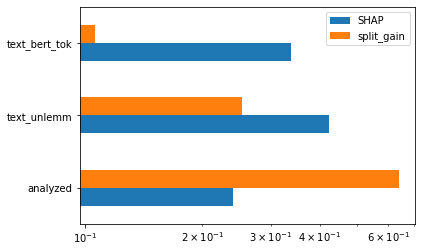

In [15]:
draw_df = summary.copy(deep=True)
del draw_df['mean']
del draw_df['split_num']
draw_df.plot.barh(logx=True,xlabel='')

In [16]:
import re
from collections import defaultdict
class_list = defaultdict(list)
def classify(fn):
    for group, plist in {
        'Translation Model': ['IBM'],
        'Proximity': ['Unordered','Ordered','TPscore','tpDist','Proximity'],
        'Relevance Model':['sum_BM25','sum_LMD','sum_DFR','sum_DPH','NTFIDF','Prob','LTFIDF_sum','SCS'],
        'Stats':['max','min','median','avg','sum','var','confidence','maxminratio','Length','Term','Size','Coverage']
    }.items():
        for p in plist:
            if re.search(p, fn):
                return group
    print(fn)
    return 'others'
for fn in fis.index.to_list():
    print(fn,classify(fn))
    class_list[classify(fn)].append(fn)
summary = {}
for f_class, fns in class_list.items():
    summary[f_class] = fis.loc[fns,:].sum()
summary = pd.DataFrame.from_dict(summary,orient='index')
summary

contents_analyzed_sum_BM25_k1_2.00_b_0.75 Relevance Model
contents_analyzed_avg_BM25_k1_2.00_b_0.75 Stats
contents_analyzed_median_BM25_k1_2.00_b_0.75 Stats
contents_analyzed_max_BM25_k1_2.00_b_0.75 Stats
contents_analyzed_min_BM25_k1_2.00_b_0.75 Stats
contents_analyzed_maxminratio_BM25_k1_2.00_b_0.75 Stats
contents_analyzed_sum_LMD_mu_1000 Relevance Model
contents_analyzed_avg_LMD_mu_1000 Stats
contents_analyzed_median_LMD_mu_1000 Stats
contents_analyzed_max_LMD_mu_1000 Stats
contents_analyzed_min_LMD_mu_1000 Stats
contents_analyzed_maxminratio_LMD_mu_1000 Stats
contents_analyzed_NTFIDF Relevance Model
contents_analyzed_Prob Relevance Model
contents_analyzed_sum_DFR_GL2 Relevance Model
contents_analyzed_avg_DFR_GL2 Stats
contents_analyzed_median_DFR_GL2 Stats
contents_analyzed_max_DFR_GL2 Stats
contents_analyzed_min_DFR_GL2 Stats
contents_analyzed_maxminratio_DFR_GL2 Stats
contents_analyzed_sum_DFR_In_expB2 Relevance Model
contents_analyzed_avg_DFR_In_expB2 Stats
contents_analyzed_med

SHAP  split_num  split_gain      mean
Relevance Model    0.167030   0.130624    0.518226  0.028002
Stats              0.425616   0.648217    0.318926  0.006307
Proximity          0.113582   0.123574    0.049552  0.000383
Translation Model  0.293773   0.097585    0.113296  0.010515

<AxesSubplot:>

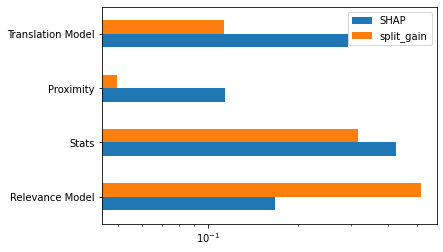

In [17]:
draw_df = summary.copy(deep=True)
del draw_df['mean']
del draw_df['split_num']
draw_df.plot.barh(logx=True,xlabel='')

In [18]:
list(filter(lambda x:re.search('QueryCoverageRatio',x), feature_used))

['contents_analyzed_QueryCoverageRatio',
 'contents_text_unlemm_QueryCoverageRatio',
 'contents_text_bert_tok_QueryCoverageRatio']

<AxesSubplot:>

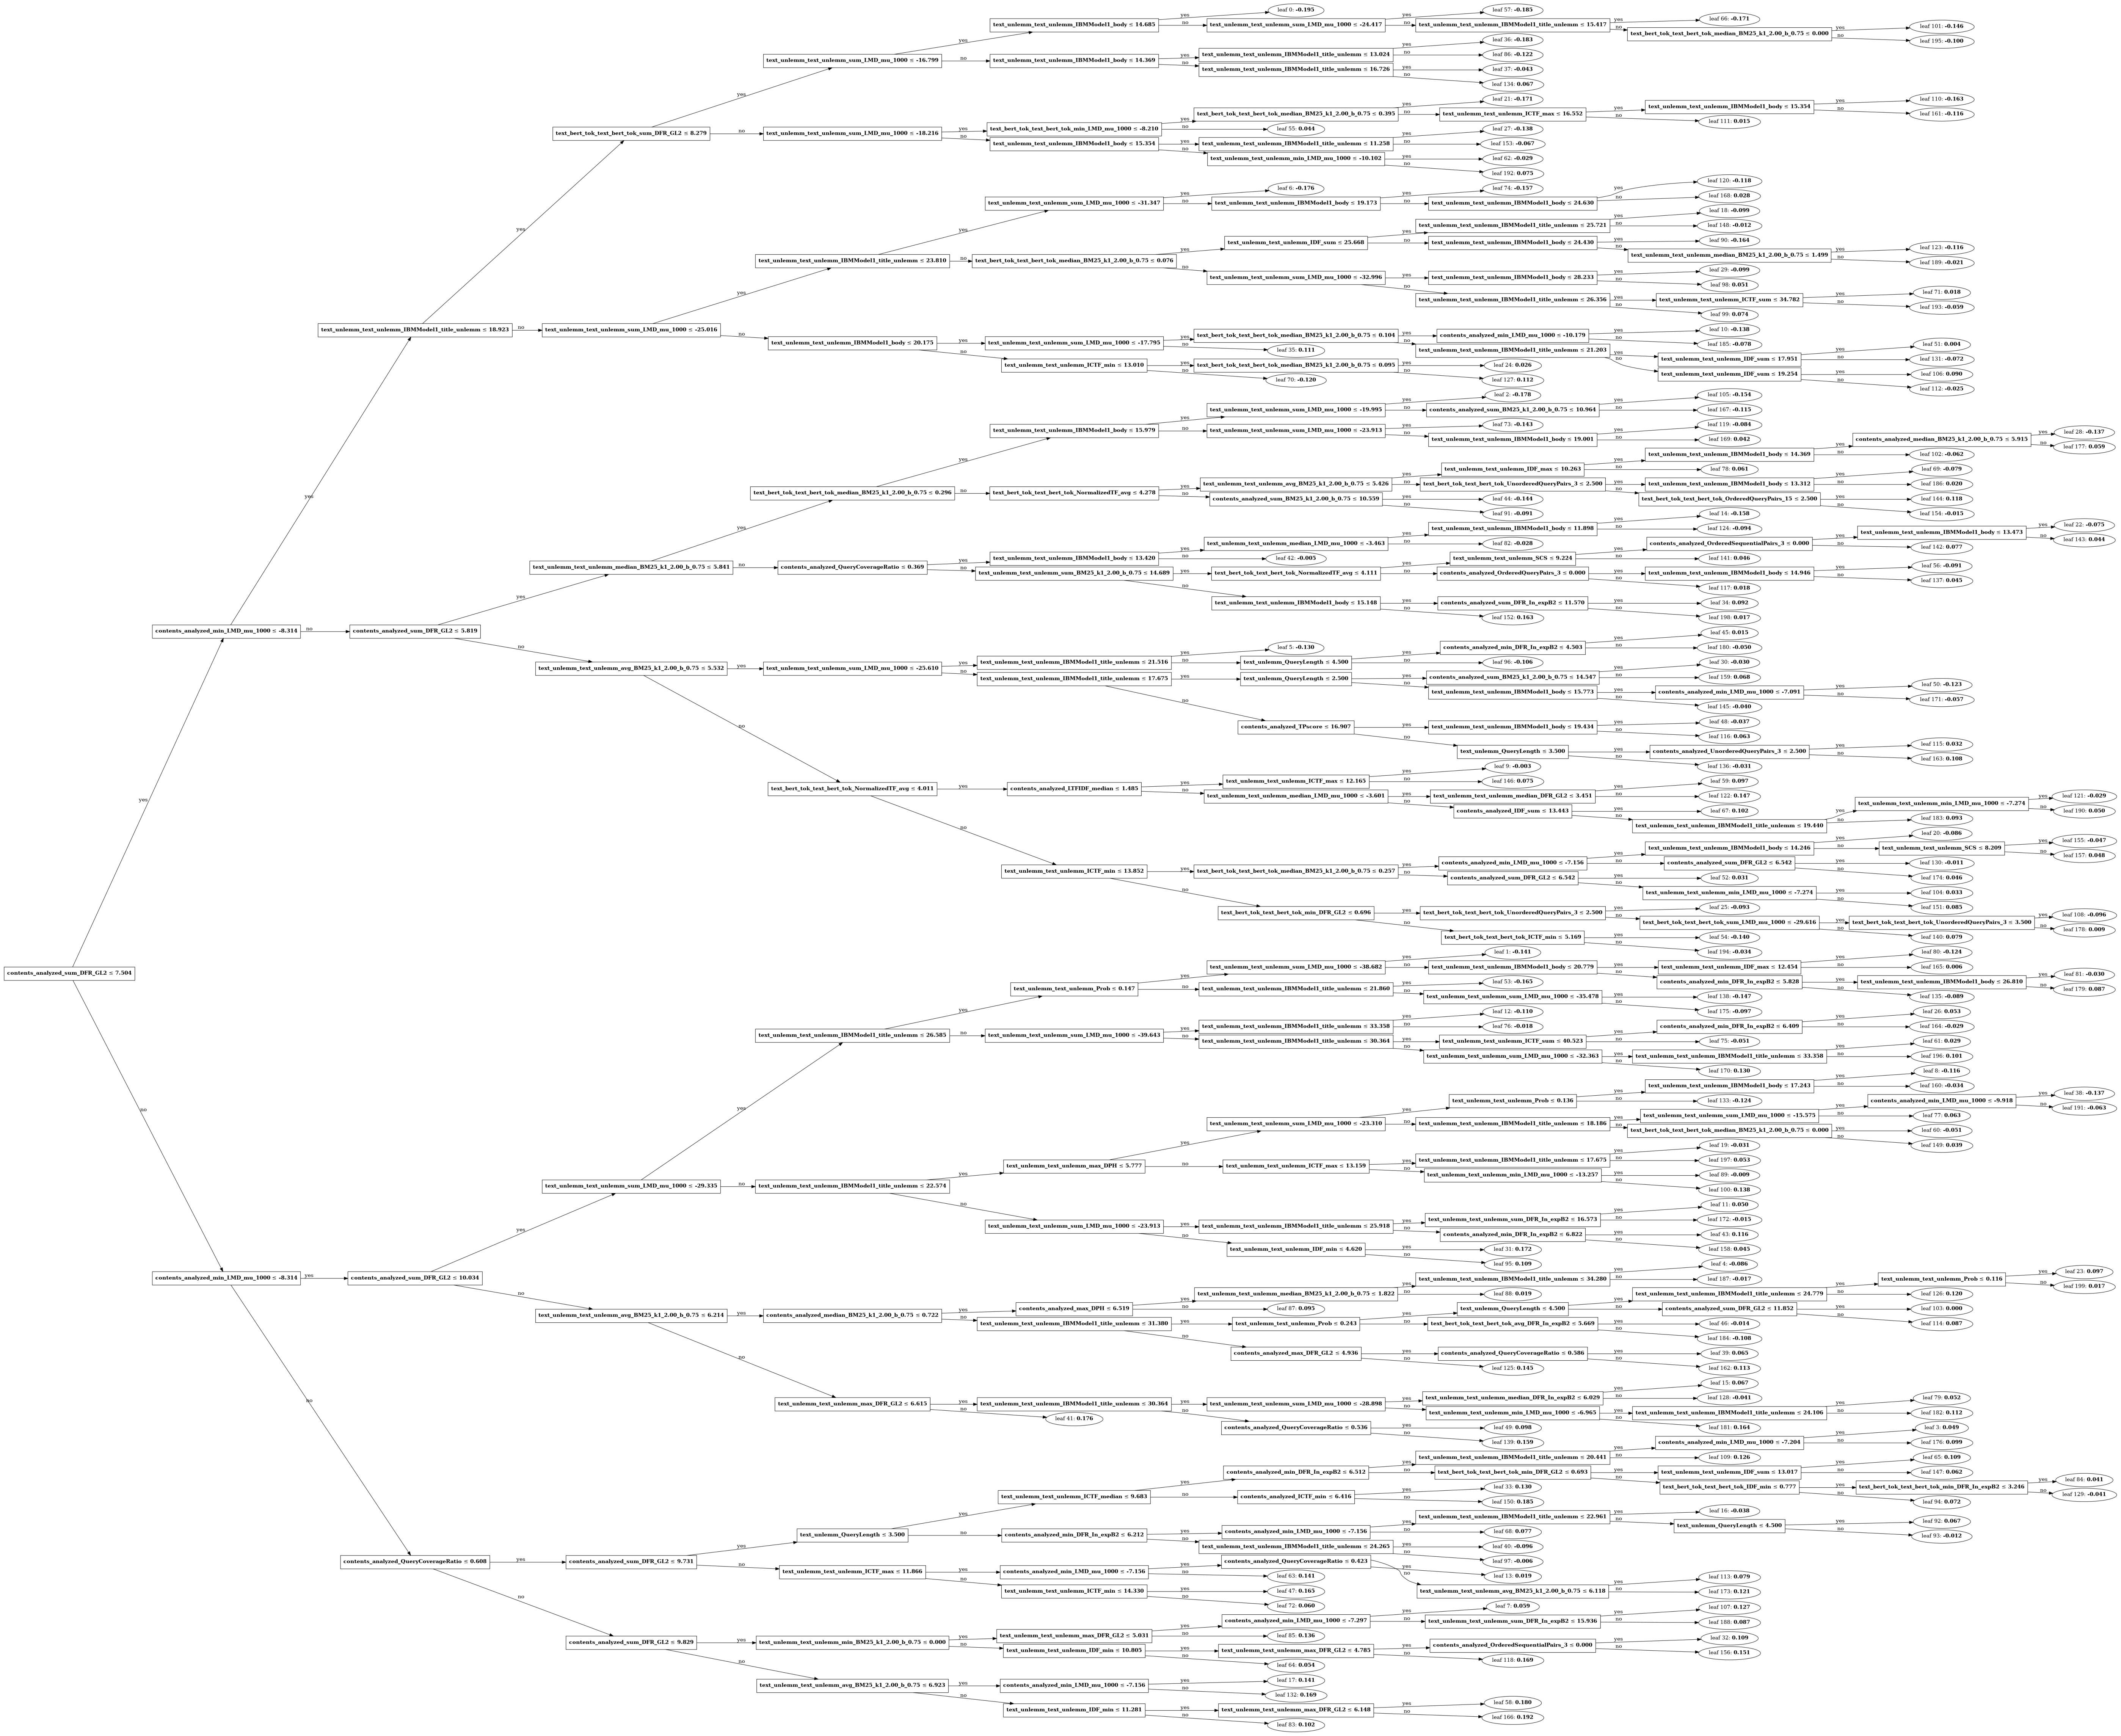

In [3]:
lgb.plot_tree(model,tree_index=0,figsize=(100,100))

In [7]:
fdf = model.trees_to_dataframe()
fdf.groupby('split_feature').mean().sort_values('split_gain',ascending=False)

tree_index  node_depth  \
split_feature                                                             
contents_analyzed_sum_DFR_GL2                    171.511905    8.790476   
contents_analyzed_min_LMD_mu_1000                146.551325    8.453642   
contents_analyzed_QueryCoverageRatio             109.431818    7.676136   
text_unlemm_text_unlemm_sum_LMD_mu_1000           78.505460    7.823713   
text_unlemm_text_unlemm_avg_BM25_k1_2.00_b_0.75  183.541254    9.993399   
...                                                     ...         ...   
text_bert_tok_text_bert_tok_IDF_maxminratio      261.612167   13.007605   
text_bert_tok_text_bert_tok_IDF_median           262.565789   12.684211   
text_bert_tok_text_bert_tok_tpDistWindow100      249.071429   10.642857   
analyzed_UniqueQueryTerms                        303.750000    9.250000   
text_bert_tok_text_bert_tok_TF_min               282.857143   11.285714   

                                                   split_gain    threshold  \
split_feature                                                                
contents_analyzed_sum_DFR_GL2                    11848.849944     8.926517   
contents_analyzed_min_LMD_mu_1000                 1977.490694    -7.748704   
contents_analyzed_QueryCoverageRatio               902.299934     0.587463   
text_unlemm_text_unlemm_sum_LMD_mu_1000            684.280308   -25.713101   
text_unlemm_text_unlemm_avg_BM25_k1_2.00_b_0.75    675.126362     6.217499   
...                                                       ...          ...   
text_bert_tok_text_bert_tok_IDF_maxminratio         13.472680     7.132011   
text_bert_tok_text_bert_tok_IDF_median              13.227974     3.236128   
text_bert_tok_text_bert_tok_tpDistWindow100         12.642583  2815.849681   
analyzed_UniqueQueryTerms                           12.019200     4.750000   
text_bert_tok_text_bert_tok_TF_min                  11.662189     3.071429   

                                                    value        weight  \
split_feature                                                             
contents_analyzed_sum_DFR_GL2                    0.004365  31713.856703   
contents_analyzed_min_LMD_mu_1000               -0.005128  33060.386556   
contents_analyzed_QueryCoverageRatio             0.010933  29808.627664   
text_unlemm_text_unlemm_sum_LMD_mu_1000         -0.023823  18586.342568   
text_unlemm_text_unlemm_avg_BM25_k1_2.00_b_0.75 -0.010943  13490.432502   
...                                                   ...           ...   
text_bert_tok_text_bert_tok_IDF_maxminratio     -0.010485    613.384253   
text_bert_tok_text_bert_tok_IDF_median          -0.004092    883.807009   
text_bert_tok_text_bert_tok_tpDistWindow100      0.003476   4340.565286   
analyzed_UniqueQueryTerms                       -0.013870   1119.550625   
text_bert_tok_text_bert_tok_TF_min              -0.019535  13364.027429   

                                                         count  
split_feature                                                   
contents_analyzed_sum_DFR_GL2                    953978.595238  
contents_analyzed_min_LMD_mu_1000                582818.288079  
contents_analyzed_QueryCoverageRatio             308728.198864  
text_unlemm_text_unlemm_sum_LMD_mu_1000          497255.563183  
text_unlemm_text_unlemm_avg_BM25_k1_2.00_b_0.75  285650.514851  
...                                                        ...  
text_bert_tok_text_bert_tok_IDF_maxminratio       23005.129278  
text_bert_tok_text_bert_tok_IDF_median            29846.131579  
text_bert_tok_text_bert_tok_tpDistWindow100      141532.928571  
analyzed_UniqueQueryTerms                         87199.750000  
text_bert_tok_text_bert_tok_TF_min               438392.428571  

[250 rows x 7 columns]

In [9]:
fdf[fdf['split_feature'] == 'contents_analyzed_sum_DFR_GL2'].head(20)

tree_index  node_depth node_index left_child right_child parent_index  \
0             0           1       0-S0       0-S1        0-S2         None   
85            0           3       0-S4      0-S13        0-S8         0-S1   
197           0           9     0-S173     0-L130      0-L174       0-S129   
200           0           8     0-S103      0-L52      0-S150        0-S51   
217           0           3       0-S3       0-S7       0-S14         0-S2   
304           0           9     0-S113     0-L103      0-L114       0-S102   
331           0           4      0-S12      0-S15       0-S46         0-S6   
374           0           4      0-S16      0-S31       0-S57         0-S6   
399           1           1       1-S0       1-S2        1-S1         None   
566           1           3       1-S3       1-S7        1-S8         1-S1   
649           1           6      1-S44      1-S51       1-L45        1-S27   
666           1           5      1-S15      1-S19       1-S73         1-S8   
722           1           6      1-S73     1-S131       1-L74        1-S15   
731           1           3       1-S4       1-S9       1-S29         1-S1   
756           1           7      1-S69      1-L10       1-S80        1-S54   
774           1           7      1-S71     1-S179      1-S175        1-S38   
784           1           5      1-S53     1-S124       1-L54        1-S29   
790           1           6      1-S61     1-S163       1-L62        1-S42   
798           2           1       2-S0       2-S1        2-S2         None   
961           2           3       2-S5       2-S8       2-S10         2-S2   

                     split_feature     split_gain  threshold decision_type  \
0    contents_analyzed_sum_DFR_GL2  503309.000000   7.504079            <=   
85   contents_analyzed_sum_DFR_GL2   22412.000000   5.818829            <=   
197  contents_analyzed_sum_DFR_GL2     182.940994   6.541956            <=   
200  contents_analyzed_sum_DFR_GL2     331.723999   6.541956            <=   
217  contents_analyzed_sum_DFR_GL2   23627.699219  10.034452            <=   
304  contents_analyzed_sum_DFR_GL2     303.532990  11.852197            <=   
331  contents_analyzed_sum_DFR_GL2    5015.020020   9.730987            <=   
374  contents_analyzed_sum_DFR_GL2    3255.800049   9.828838            <=   
399  contents_analyzed_sum_DFR_GL2  742438.000000   7.049618            <=   
566  contents_analyzed_sum_DFR_GL2   51691.398438   8.849918            <=   
649  contents_analyzed_sum_DFR_GL2    2315.389893  12.668607            <=   
666  contents_analyzed_sum_DFR_GL2    8469.089844  13.027246            <=   
722  contents_analyzed_sum_DFR_GL2    1114.520020  15.589465            <=   
731  contents_analyzed_sum_DFR_GL2   32728.699219  11.245372            <=   
756  contents_analyzed_sum_DFR_GL2    1159.829956   8.442483            <=   
774  contents_analyzed_sum_DFR_GL2    1127.979980   8.913160            <=   
784  contents_analyzed_sum_DFR_GL2    1603.300049  13.433472            <=   
790  contents_analyzed_sum_DFR_GL2    1426.660034  13.433472            <=   
798  contents_analyzed_sum_DFR_GL2  570230.000000   7.236402            <=   
961  contents_analyzed_sum_DFR_GL2   25208.500000   9.182728            <=   

    missing_direction missing_type     value     weight    count  
0                left         None  0.000000       0.00  8385888  
85               left         None -0.034958   70989.30  1702222  
197              left         None  0.022010    2275.70    42116  
200              left         None  0.057057    7633.31   118233  
217              left         None  0.024860   60664.60  1151213  
304              left         None  0.030905    1759.71    32530  
331              left         None  0.101100   44204.90   504513  
374              left         None  0.167133   97867.40   512587  
399              left         None  0.000000       0.00  8385888  
566              left         None  0.016794  352896.00  

In [11]:
fdf[fdf['split_feature'] == 'text_unlemm_text_unlemm_IBMModel1_body'].head(20)

tree_index  node_depth node_index left_child right_child parent_index  \
5             0           6      0-S56       0-L0       0-S65        0-S35   
14            0           6      0-S36      0-S85      0-S133        0-S35   
26            0           9     0-S160     0-L110      0-L161       0-S110   
31            0           6      0-S61     0-S152      0-S191        0-S26   
42            0           7     0-S119      0-L74      0-S167        0-S73   
44            0           8     0-S167     0-L120      0-L168       0-S119   
52            0           8     0-S122      0-L90      0-S188        0-S89   
58            0           8      0-S97      0-L29       0-L98        0-S70   
66            0           5      0-S23      0-S34       0-S69         0-S9   
88            0           6      0-S72     0-S104      0-S118        0-S27   
96            0           8     0-S168     0-L119      0-L169       0-S118   
102           0           9     0-S101     0-S176      0-L102        0-S77   
109           0           9     0-S185      0-L69      0-L186       0-S143   
119           0           6      0-S41      0-S81       0-L42        0-S21   
121           0           8     0-S123      0-L14      0-L124        0-S81   
130           0          10     0-S142      0-L22      0-L143       0-S141   
136           0           9     0-S136      0-L56      0-L137       0-S116   
140           0           7     0-S151     0-S197      0-L152        0-S33   
159           0           8     0-S144     0-S170      0-L145        0-S49   
165           0           8     0-S115      0-L48      0-L116       0-S114   

                              split_feature   split_gain  threshold  \
5    text_unlemm_text_unlemm_IBMModel1_body   683.445984  14.685152   
14   text_unlemm_text_unlemm_IBMModel1_body  2173.080078  14.369060   
26   text_unlemm_text_unlemm_IBMModel1_body   195.492004  15.353524   
31   text_unlemm_text_unlemm_IBMModel1_body   659.377991  15.353524   
42   text_unlemm_text_unlemm_IBMModel1_body   285.838013  19.173011   
44   text_unlemm_text_unlemm_IBMModel1_body   186.681000  24.629510   
52   text_unlemm_text_unlemm_IBMModel1_body   282.800995  24.430261   
58   text_unlemm_text_unlemm_IBMModel1_body   344.307007  28.232861   
66   text_unlemm_text_unlemm_IBMModel1_body  1783.099976  20.174729   
88   text_unlemm_text_unlemm_IBMModel1_body   505.226990  15.979437   
96   text_unlemm_text_unlemm_IBMModel1_body   186.233994  19.000710   
102  text_unlemm_text_unlemm_IBMModel1_body   337.200989  14.369060   
109  text_unlemm_text_unlemm_IBMModel1_body   170.528000  13.312318   
119  text_unlemm_text_unlemm_IBMModel1_body   951.698975  13.420456   
121  text_unlemm_text_unlemm_IBMModel1_body   280.957001  11.898499   
130  text_unlemm_text_unlemm_IBMModel1_body   274.895996  13.473417   
136  text_unlemm_text_unlemm_IBMModel1_body   247.466995  14.946445   
140  text_unlemm_text_unlemm_IBMModel1_body   221.529007  15.148237   
159  text_unlemm_text_unlemm_IBMModel1_body   233.065002  15.772707   
165  text_unlemm_text_unlemm_IBMModel1_body   369.217987  19.433691   

    decision_type missing_direction missing_type     value    weight    count  
5              <=              left         None -0.189783  75992.50  2999158  
14             <=              left         None -0.147344   7046.35   248061  
26             <=              left         None -0.140717   3661.05   127292  
31             <=              left         None -0.066561   2409.02    65604  
42             <=              left         None -0.135406   5824.43   197578  
44             <=              left         None -0.112916   2868.20    91090  
52             <=              left         None -0.133025   2796.09    95507  
58             <=              left         None -0.072708   1059.93    30164  
66             <=              left         None -0.010250   7198.84   158424  
88             <=              left         None -0.144952  11605.30   402

In [23]:
for fn, group in fdf[fdf['node_depth'] == 2].groupby('split_feature'):
    print(fn)
    print(group[['tree_index','split_gain','count']])

contents_analyzed_ICTF_sum
        tree_index  split_gain    count
95362          239   20.349100  4120801
100948         253   17.437000  4619604
107332         269   16.335199  3860339
111322         279   14.662200  4884370
112519         282   13.462300  3366888
115312         289   16.818701  6478579
116908         293   13.238000  5015298
119302         299   15.695100  6709981
120499         302   14.385800  6709981
125287         314   11.115000  2734269
134464         337   11.038800  6142568
135661         340   11.621800  6775359
146833         368    9.445620  7536674
150823         378    8.046170  4619604
153217         384    8.582660  7633447
contents_analyzed_IDF_sum
        tree_index  split_gain    count
106534         267     17.8522  7536674
114514         287     13.2434  3892213
115711         290     14.4439  7536674
147631         370     10.3841  7034961
contents_analyzed_LTFIDF_maxminratio
       tree_index  split_gain    count
17752          44  920.169983  